In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

dirs = ['../DataGeneration/Python', './net/']
for d in dirs:
    if d not in sys.path:
        sys.path.append(d)

import Sample
import Dataloader

from Transformer import Transformer

In [2]:
## Boilerplate setup code

TRAIN_DATASET_PATH = '../Dataset/CC10k.npy'
VAL_DATASET_PATH = '../Dataset/CCVal300.npy'
N_WORKERS = 0

# From data
d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
BATCH_SIZE = 10

# Load some of our data
data_train = Dataloader.formattedLoader(d_input, d_output, TRAIN_DATASET_PATH) # Get input data formatted for network
data_val = Dataloader.formattedLoader(d_input, d_output, VAL_DATASET_PATH) # Get input data formatted for network

dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

In [ ]:
## Pull in the model
#model_path = 'Checkpoints/model_2023_03_26__131119.pth'
def load_model(model_path):
    state_dict = torch.load(model_path)
    optimizePrime = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
    optimizePrime.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(optimizePrime.parameters(), lr=LR)
    return optimizePrime

In [3]:
def fit(model, optimizer, loss_function, EPOCHS, model_save_path, perturb=False, noise_scale=.1):
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_loss_best = np.inf 


    for epoch in range(EPOCHS):
        with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCHS}]") as pbar:
            
            # Training phase
            model.train()
            running_loss = 0

            for i, (x, y) in enumerate(dataloader_train):
                
                if perturb:
                    # Add random noise to the input tensor
                    noise_tensor = torch.randn_like(x) * noise_scale  # 0.1 is the noise scale
                    perturbed_input = x + noise_tensor                

                # Forward pass
                optimizer.zero_grad()
                x = x.float()
                yhat = model(x)
                loss = loss_function(y.float(), yhat)

                # Back pass
                loss.backward()
                optimizer.step()

                running_loss+= loss.item()
                pbar.set_postfix({'total loss': running_loss})
                pbar.update(x.shape[0])

            performance = running_loss / len(dataloader_train.dataset)
            epoch_train_loss.append(performance)
            print(f"Epoch {epoch} train_loss: {performance}")

            # Validation phase
            model.eval()
            running_loss = 0

            with torch.no_grad():
                for i, (x, y) in enumerate(dataloader_val):
                    
                    # Forward pass
                    x = x.float()
                    yhat = model(x)
                    loss = loss_function(y.float(), yhat)
                    running_loss+= loss.item()

                # Loss per sample
                performance = running_loss / len(dataloader_val.dataset)
                epoch_val_loss.append(performance)
                print(f"Epoch {epoch} val_loss: {performance}")

        if epoch_val_loss[-1] < epoch_loss_best:
            epoch_loss_best = performance
            torch.save(model.state_dict(), model_save_path)
    return epoch_train_loss, epoch_val_loss    


# Model 1

In [106]:
## Model 1 Architecture ##
d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10

# Model hyperparameters
BATCH_SIZE = 4
D_MODEL = 16
q = 8 
v = 8
h = 8
Ne = 6
Nd = 6
DROPOUT = 0.1

LR = .001

In [107]:
model1 = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
optimizer = torch.optim.Adam(model1.parameters(), lr=LR)
loss_function = nn.MSELoss()
model_save_path = f'Checkpoints/model1_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
EPOCHS=10

In [108]:
train_loss, val_loss = fit(model1, optimizer, loss_function, EPOCHS, model_save_path)

[Epoch   1/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 242.54it/s, total loss=2.94e+5]

Epoch 0 train_loss: 29.378517385864257


[Epoch   1/10]: 100%|██████████| 10000/10000 [00:43<00:00, 231.10it/s, total loss=2.94e+5]


Checkpoint model_2023_03_26__131119.pth val_loss: 25.113507080078126


[Epoch   2/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 235.14it/s, total loss=2.18e+5]

Epoch 1 train_loss: 21.79367232055664


[Epoch   2/10]: 100%|██████████| 10000/10000 [00:42<00:00, 234.73it/s, total loss=2.18e+5]


Checkpoint model_2023_03_26__131119.pth val_loss: 19.203669840494793


[Epoch   3/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 219.19it/s, total loss=1.7e+5]

Epoch 2 train_loss: 17.02611489868164


[Epoch   3/10]: 100%|██████████| 10000/10000 [00:42<00:00, 233.78it/s, total loss=1.7e+5]


Checkpoint model_2023_03_26__131119.pth val_loss: 15.117486775716145


[Epoch   4/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 235.55it/s, total loss=1.34e+5]

Epoch 3 train_loss: 13.4118642288208


[Epoch   4/10]: 100%|██████████| 10000/10000 [00:42<00:00, 233.23it/s, total loss=1.34e+5]


Checkpoint model_2023_03_26__131119.pth val_loss: 11.87071024576823


[Epoch   5/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 242.08it/s, total loss=1.05e+5]

Epoch 4 train_loss: 10.50754351348877


[Epoch   5/10]: 100%|██████████| 10000/10000 [00:42<00:00, 233.00it/s, total loss=1.05e+5]


Checkpoint model_2023_03_26__131119.pth val_loss: 9.240069986979167


[Epoch   6/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 236.91it/s, total loss=8.17e+4]

Epoch 5 train_loss: 8.174818297576904


[Epoch   6/10]: 100%|██████████| 10000/10000 [00:42<00:00, 234.43it/s, total loss=8.17e+4]


Checkpoint model_2023_03_26__131119.pth val_loss: 7.132104593912761


[Epoch   7/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 238.08it/s, total loss=6.31e+4]

Epoch 6 train_loss: 6.3098533203125


[Epoch   7/10]: 100%|██████████| 10000/10000 [00:42<00:00, 236.01it/s, total loss=6.31e+4]


Checkpoint model_2023_03_26__131119.pth val_loss: 5.470851236979167


[Epoch   8/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 241.09it/s, total loss=4.83e+4]

Epoch 7 train_loss: 4.829906094360352


[Epoch   8/10]: 100%|██████████| 10000/10000 [00:42<00:00, 233.44it/s, total loss=4.83e+4]


Checkpoint model_2023_03_26__131119.pth val_loss: 4.149268417358399


[Epoch   9/10]: 100%|█████████▉| 9984/10000 [00:42<00:00, 241.52it/s, total loss=3.68e+4]

Epoch 8 train_loss: 3.6785093254089354


[Epoch   9/10]: 100%|██████████| 10000/10000 [00:42<00:00, 233.30it/s, total loss=3.68e+4]


Checkpoint model_2023_03_26__131119.pth val_loss: 3.1570670954386393


[Epoch  10/10]: 100%|█████████▉| 9984/10000 [00:41<00:00, 238.54it/s, total loss=2.82e+4]

Epoch 9 train_loss: 2.819302479171753


[Epoch  10/10]: 100%|██████████| 10000/10000 [00:42<00:00, 236.71it/s, total loss=2.82e+4]

Checkpoint model_2023_03_26__131119.pth val_loss: 2.419100748697917


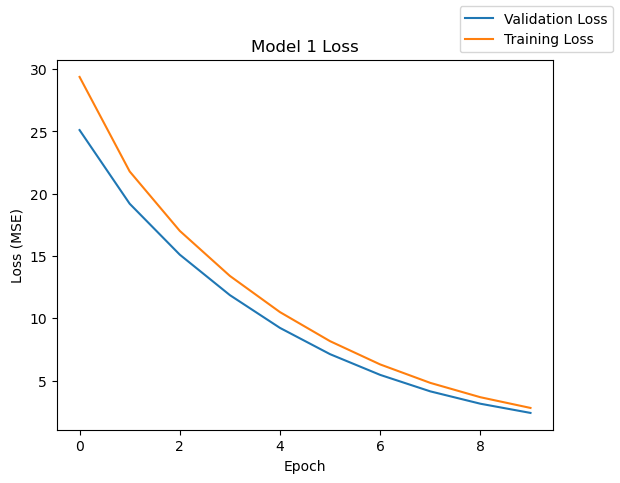

In [114]:
fig, ax = plt.subplots()
plt.plot(range(len(val_loss)), val_loss)
plt.plot(range(len(train_loss)), train_loss)
plt.title("Model 1 Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
fig.legend(["Validation Loss", "Training Loss"])

(tensor([25.1761,  3.5820,  2.4979,  1.9867, 45.4193, 83.0355,  5.1455,  5.0324,
          6.1710,  9.5812, 11.2510,  6.1903,  9.7406, 13.7053,  4.9731,  7.1802,
          9.9340,  2.8537,  4.1432,  4.0738,  1.1907,  1.4582,  0.7571,  0.2939,
          0.2547,  0.2880,  0.2827], grad_fn=<SelectBackward0>),
 tensor([25.0548,  3.5137,  2.4705,  1.9715, 45.0900, 81.7755,  4.9565,  4.9526,
          6.0605,  9.4570, 11.0859,  5.9924,  9.7299, 13.5648,  4.8722,  6.9691,
          9.7931,  2.8160,  4.0431,  4.0945,  1.2148,  1.5366,  0.7851,  0.2785,
          0.2872,  0.2865,  0.2394], grad_fn=<SelectBackward0>))

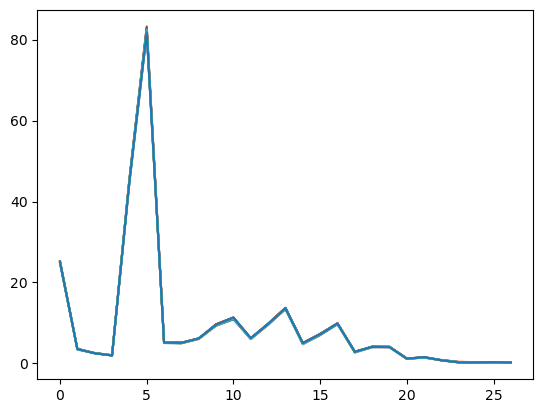

In [156]:
i=0
for c, (x, y) in enumerate(dataloader_train):
    X = model1(x.float())[i]
    X = X.detach().numpy()
    #ax.plot(range(len(y[i])), y[i])
    plt.plot(range(len(X)), X)
    #ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
    if (c == 10):
        break


model1(x.float())[0], model1(x.float())[1]

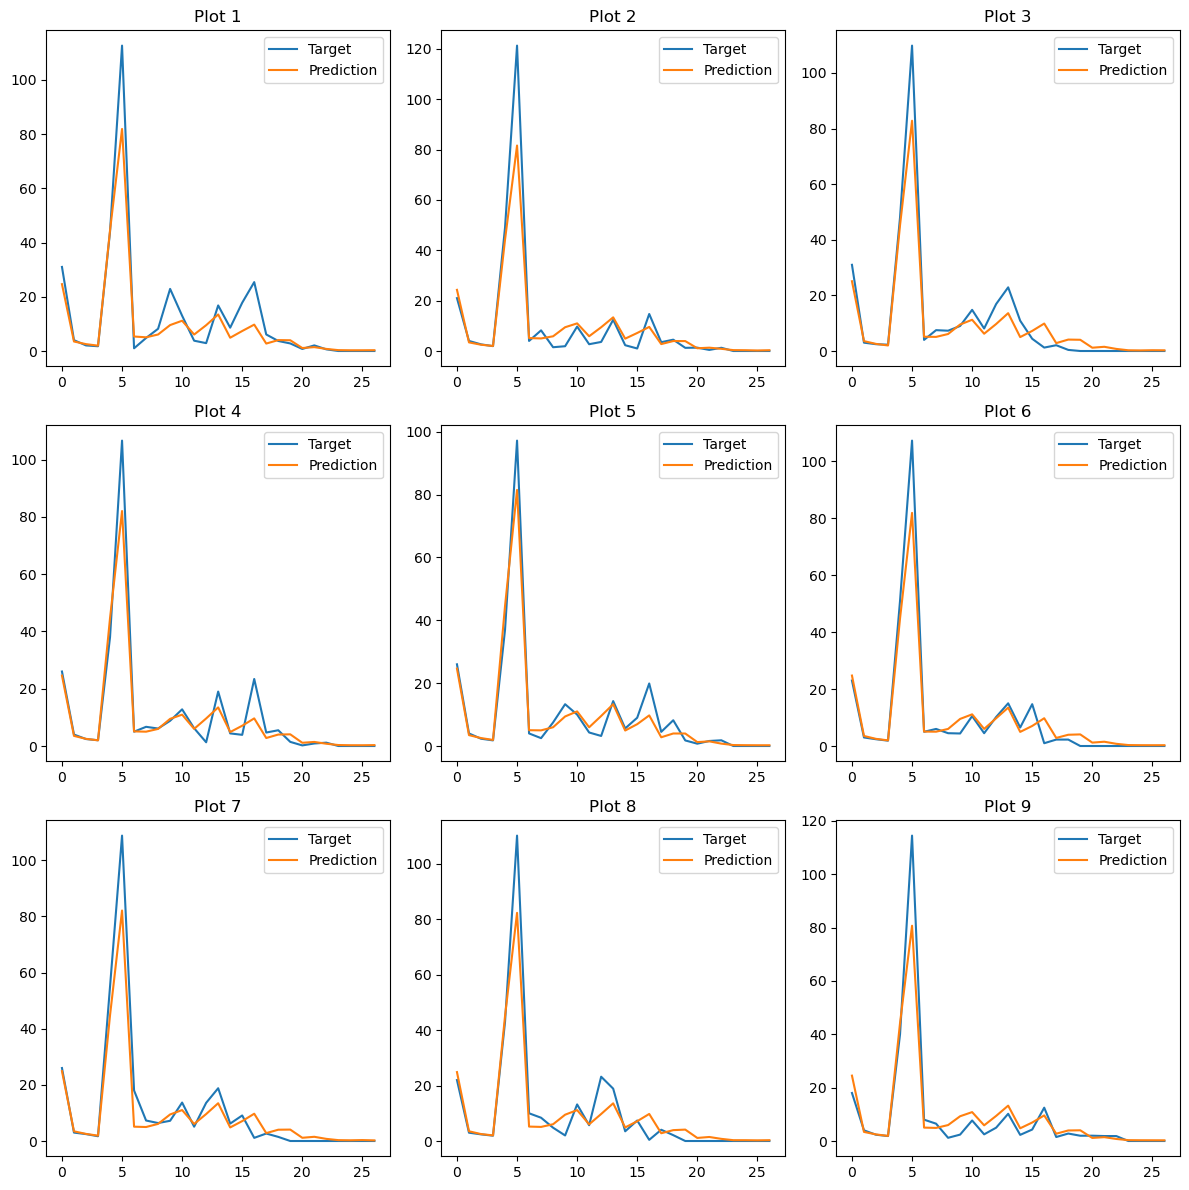

In [136]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for x, y in dataloader_train:
    break

for i, ax in enumerate(axs.flat):
    X = model1(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

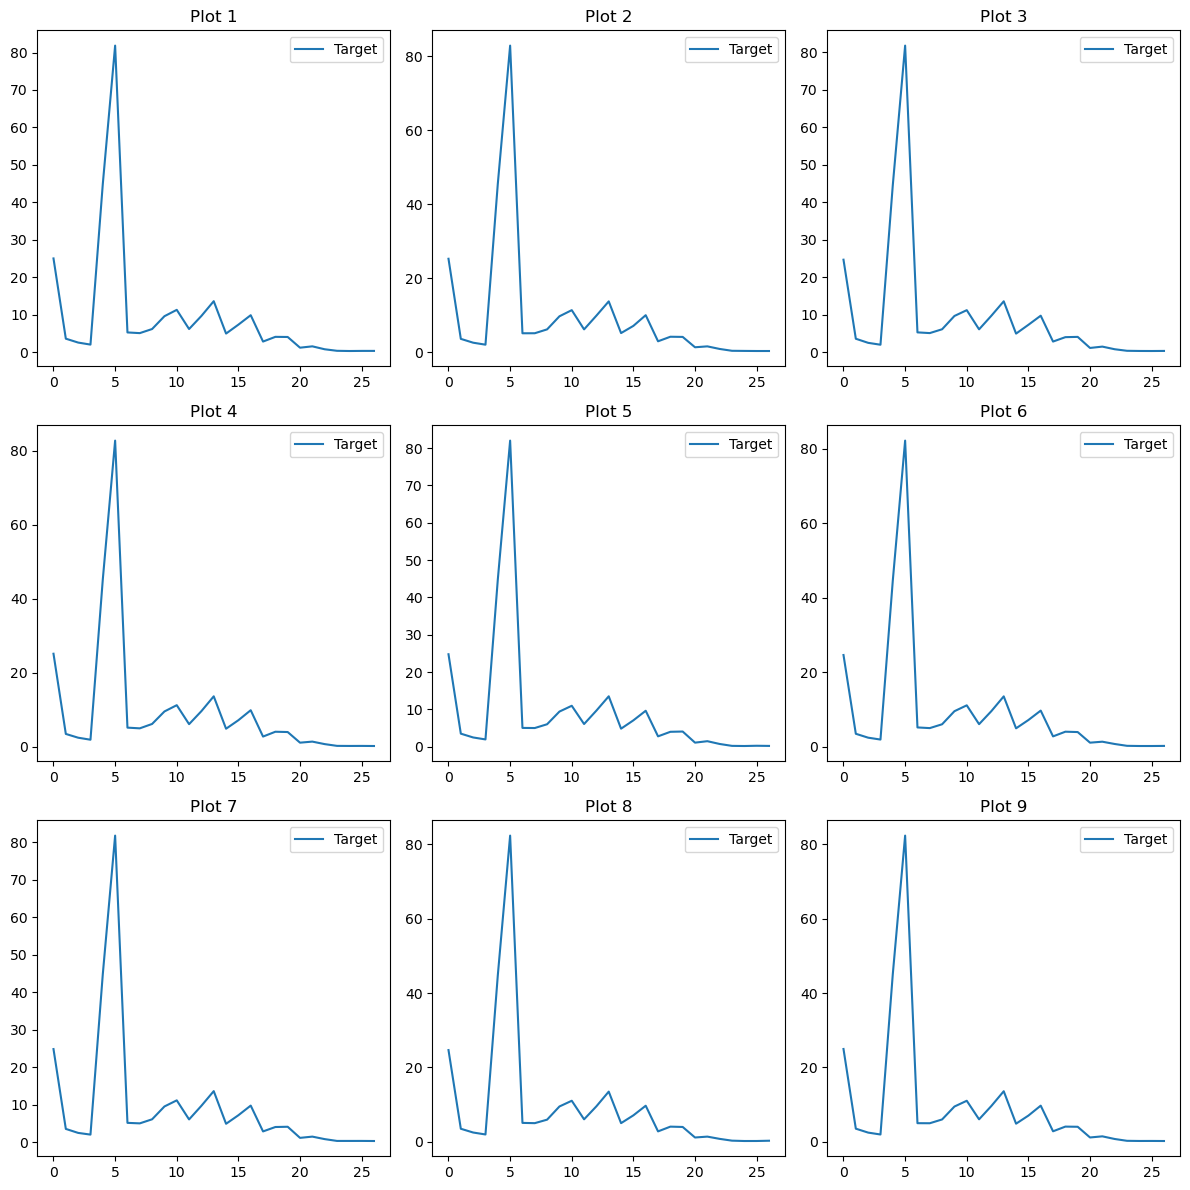

In [133]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for x, y in dataloader_train:
    break

for i, ax in enumerate(axs.flat):
    X = model1(x.float())[i]
    X = X.detach().numpy()
    #ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

# Model 2 (modified output layer)

In [23]:
## Model 2 Architecture ##
## No global mean pooling across sequence length dimension

d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10

# Model hyperparameters
BATCH_SIZE = 4
D_MODEL = 32
q = 8 
v = 8
h = 8
Ne = 6
Nd = 6
DROPOUT = 0.2
LR = .001

model2 = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT) 
optimizer = torch.optim.Adam(model2.parameters(), lr=LR)
loss_function = nn.MSELoss()
model_save_path = f'Checkpoints/model2_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
EPOCHS=10

In [24]:
train_loss, val_loss = fit(model2, optimizer, loss_function, EPOCHS, model_save_path)

[Epoch   1/10]: 100%|█████████▉| 9990/10000 [00:36<00:00, 281.04it/s, total loss=3.76e+5]

Epoch 0 train_loss: 37.56776546630859


[Epoch   1/10]: 100%|██████████| 10000/10000 [00:36<00:00, 271.48it/s, total loss=3.76e+5]


Epoch 0 val_loss: 25.36646296183268


[Epoch   2/10]: 100%|█████████▉| 9990/10000 [00:36<00:00, 278.03it/s, total loss=1.88e+5]

Epoch 1 train_loss: 18.802954247283935


[Epoch   2/10]: 100%|██████████| 10000/10000 [00:37<00:00, 268.32it/s, total loss=1.88e+5]


Epoch 1 val_loss: 13.074739939371744


[Epoch   3/10]: 100%|█████████▉| 9990/10000 [00:37<00:00, 270.79it/s, total loss=1e+5]

Epoch 2 train_loss: 10.047826250839233


[Epoch   3/10]: 100%|██████████| 10000/10000 [00:37<00:00, 264.29it/s, total loss=1e+5]


Epoch 2 val_loss: 7.277672589619955


[Epoch   4/10]: 100%|██████████| 10000/10000 [00:35<00:00, 305.94it/s, total loss=6.19e+4]

Epoch 3 train_loss: 6.188501038742065


[Epoch   4/10]: 100%|██████████| 10000/10000 [00:35<00:00, 282.09it/s, total loss=6.19e+4]


Epoch 3 val_loss: 5.013478851318359


[Epoch   5/10]: 100%|█████████▉| 9990/10000 [00:34<00:00, 188.95it/s, total loss=4.88e+4]

Epoch 4 train_loss: 4.8820118947982785


[Epoch   5/10]: 100%|██████████| 10000/10000 [00:34<00:00, 286.71it/s, total loss=4.88e+4]


Epoch 4 val_loss: 4.461148948669433


[Epoch   6/10]: 100%|█████████▉| 9990/10000 [00:35<00:00, 283.49it/s, total loss=4.64e+4]

Epoch 5 train_loss: 4.6360073387146


[Epoch   6/10]: 100%|██████████| 10000/10000 [00:35<00:00, 278.63it/s, total loss=4.64e+4]


Epoch 5 val_loss: 4.406558685302734


[Epoch   7/10]: 100%|█████████▉| 9990/10000 [00:36<00:00, 281.68it/s, total loss=4.61e+4]

Epoch 6 train_loss: 4.613602669715881


[Epoch   7/10]: 100%|██████████| 10000/10000 [00:36<00:00, 273.81it/s, total loss=4.61e+4]


Epoch 6 val_loss: 4.411994489034017


[Epoch   8/10]: 100%|█████████▉| 9990/10000 [00:35<00:00, 285.35it/s, total loss=4.59e+4]

Epoch 7 train_loss: 4.5946603153228756


[Epoch   8/10]: 100%|██████████| 10000/10000 [00:35<00:00, 279.98it/s, total loss=4.59e+4]


Epoch 7 val_loss: 4.384645709991455


[Epoch   9/10]: 100%|█████████▉| 9990/10000 [00:36<00:00, 284.82it/s, total loss=4.58e+4]

Epoch 8 train_loss: 4.579097666549683


[Epoch   9/10]: 100%|██████████| 10000/10000 [00:36<00:00, 272.16it/s, total loss=4.58e+4]


Epoch 8 val_loss: 4.36756056467692


[Epoch  10/10]: 100%|█████████▉| 9990/10000 [00:35<00:00, 288.53it/s, total loss=4.57e+4]

Epoch 9 train_loss: 4.569612489700317


[Epoch  10/10]: 100%|██████████| 10000/10000 [00:36<00:00, 277.22it/s, total loss=4.57e+4]

Epoch 9 val_loss: 4.358250967661539


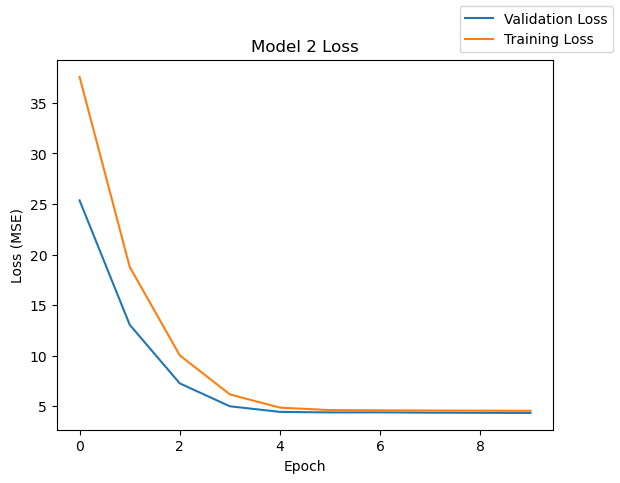

In [28]:
fig, ax = plt.subplots()
plt.plot(range(len(val_loss)), val_loss)
plt.plot(range(len(train_loss)), train_loss)
plt.title("Model 2 Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
fig.legend(["Validation Loss", "Training Loss"])

<Figure size 640x480 with 0 Axes>

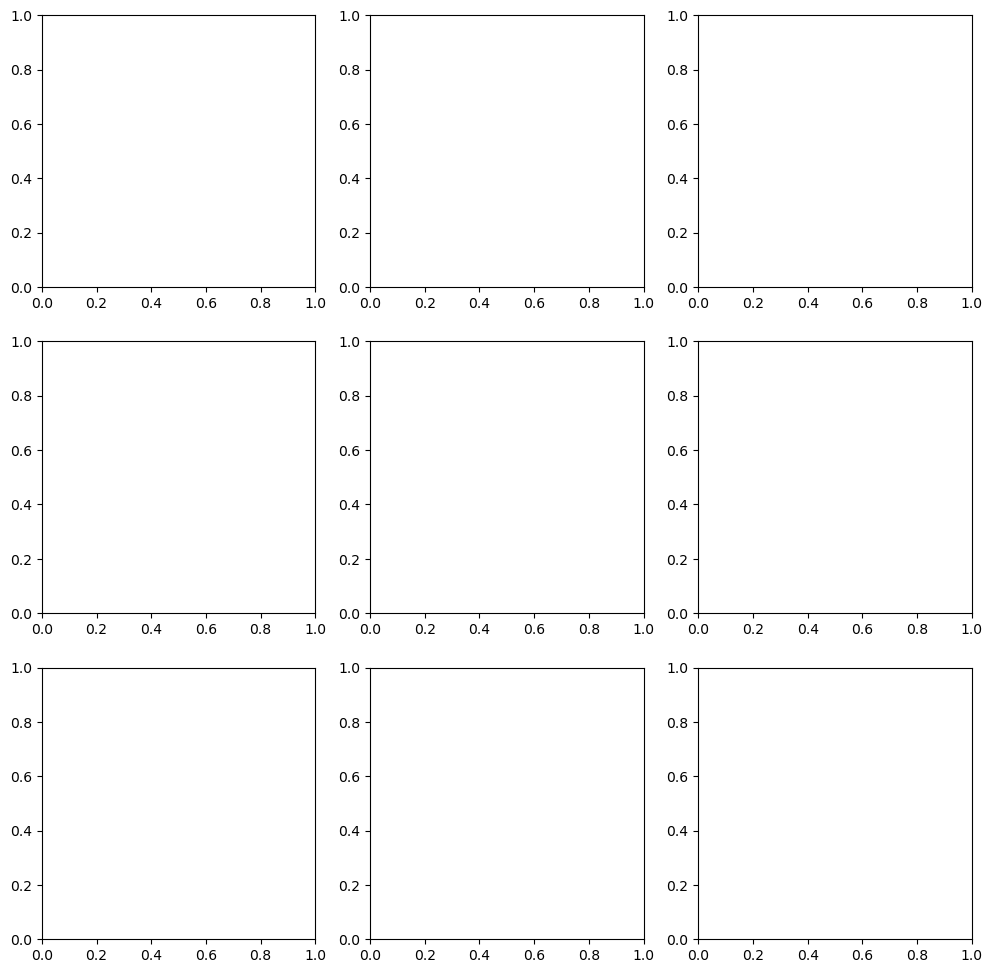

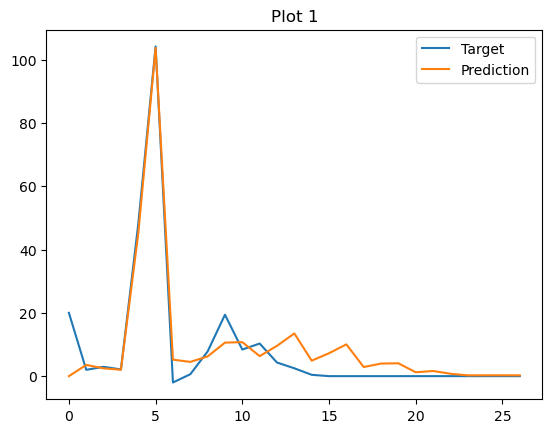

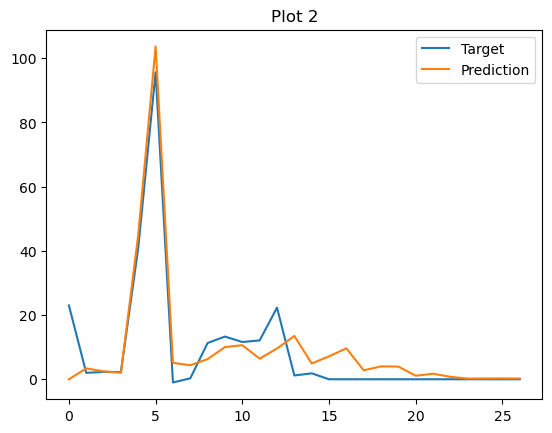

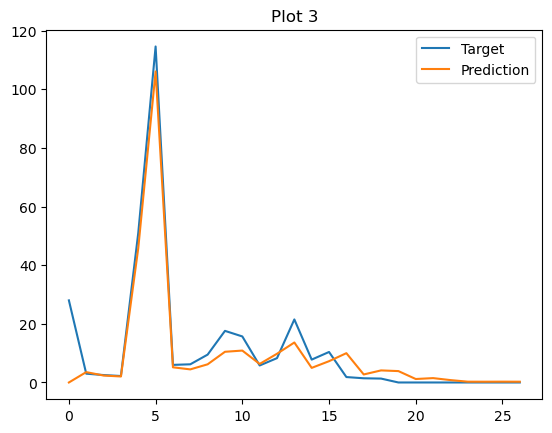

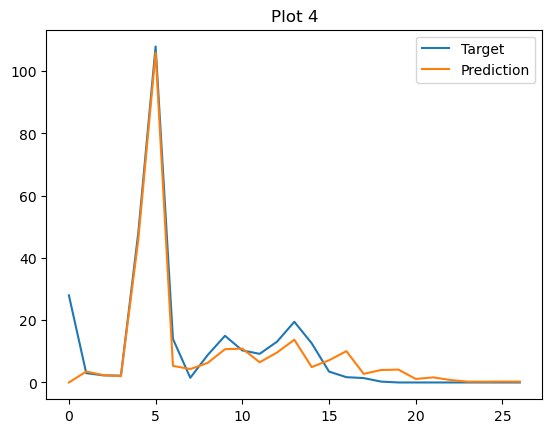

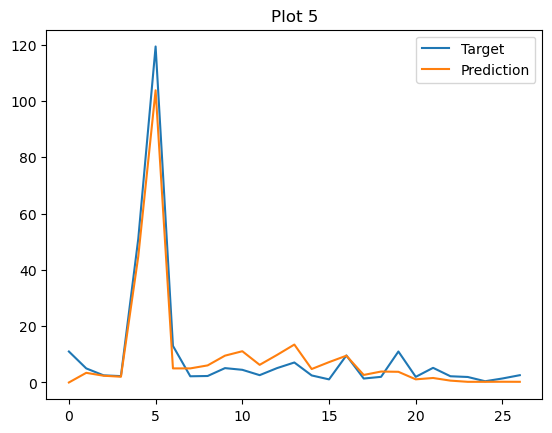

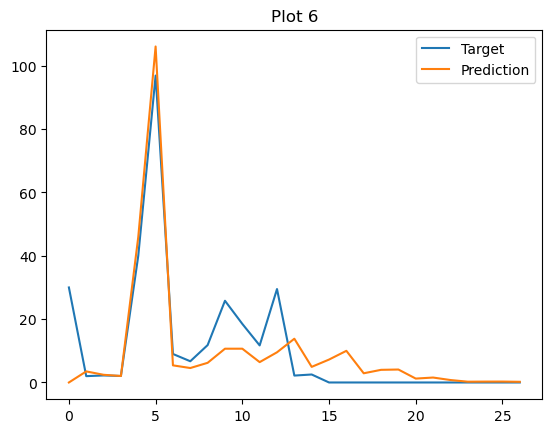

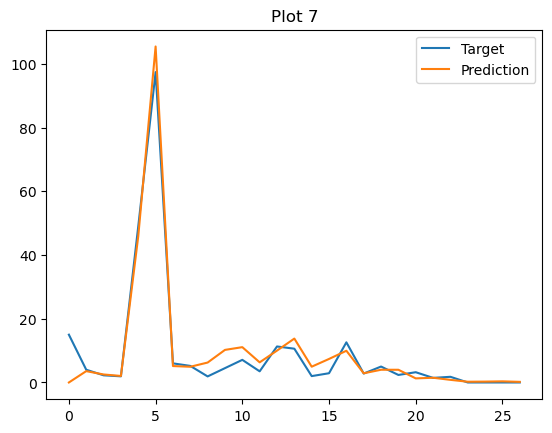

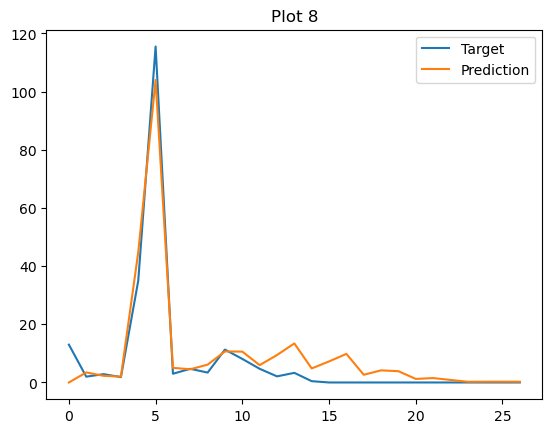

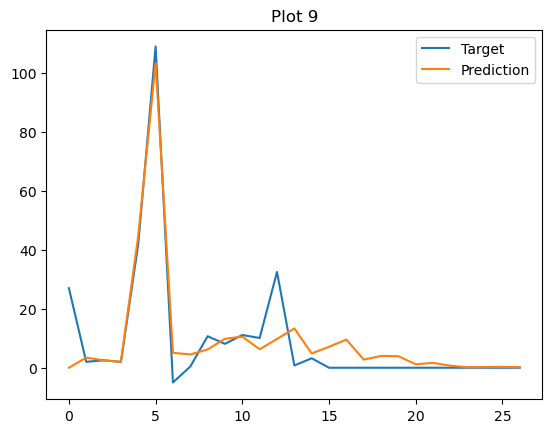

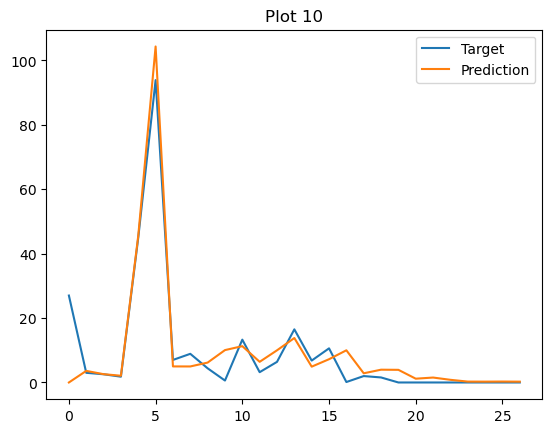

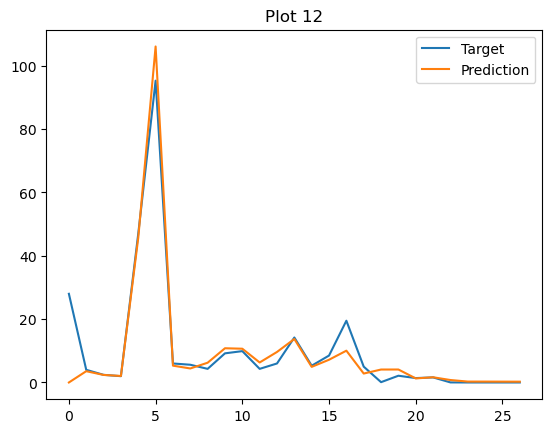

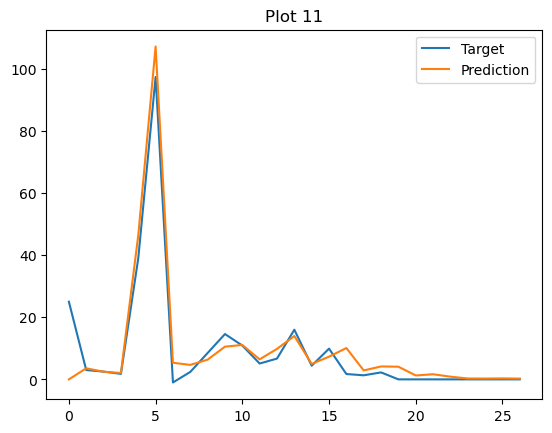

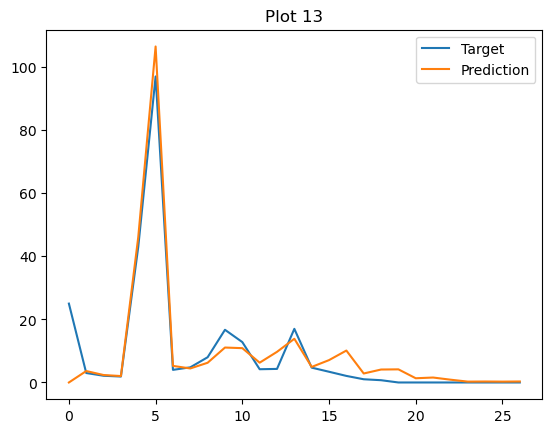

In [29]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for i, (x, y) in enumerate(dataloader_train):
    plt.figure(i)
    fig, ax = plt.subplots()
    X = model2(x.float())[0]
    X = X.detach().numpy()
    plt.plot(range(len(y[0])), y[0])
    plt.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
    if (i==12):
        break


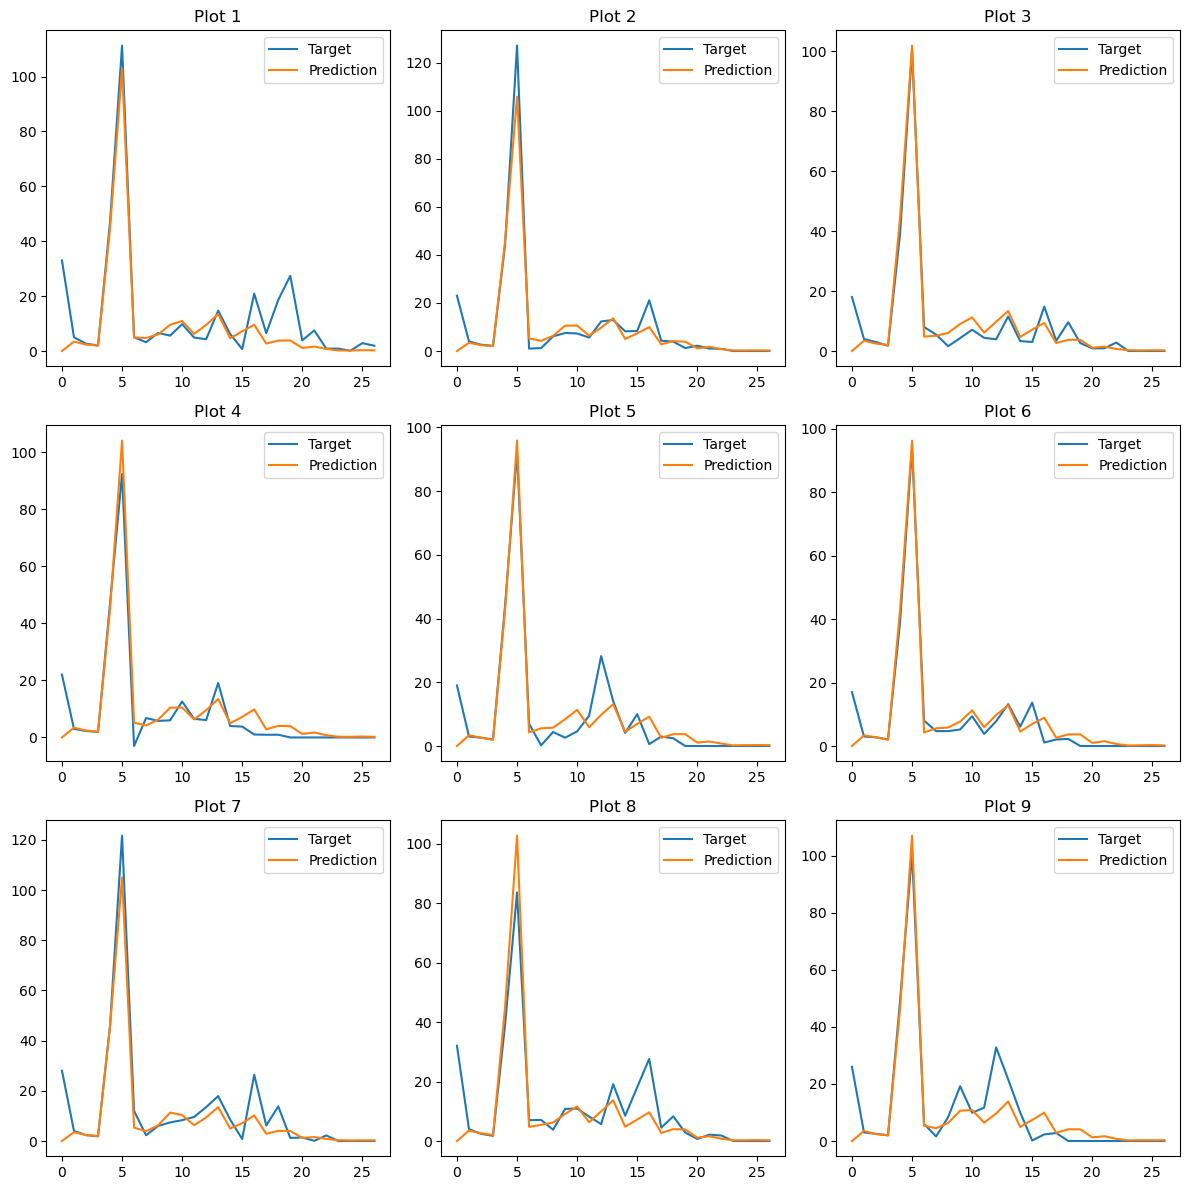

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for x, y in dataloader_train:
    break

for i, ax in enumerate(axs.flat):
    X = model2(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

In [22]:


X = model2(x.float())[0]
X.shape()

TypeError: 'torch.Size' object is not callable

# Model 3 (Optimized for Variability)

In [32]:
## Model 3 Architecture ##

d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10

# Model hyperparameters
BATCH_SIZE = 64
D_MODEL = 4
q = 6 
v = 6
h = 6
Ne = 12
Nd = 12
DROPOUT = 0
LR = .01

model3 = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT, noise_scale=.2) 
model3.init_weights()
optimizer = torch.optim.Adam(model3.parameters(), lr=LR)
loss_function = nn.MSELoss()
model_save_path = f'Checkpoints/model3_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
EPOCHS=1

In [33]:
train_loss, val_loss = fit(model3, optimizer, loss_function, EPOCHS, model_save_path, perturb=True, noise_scale=0.2)

[Epoch   1/1]:  67%|██████▋   | 6680/10000 [00:38<00:20, 162.53it/s, total loss=4.23e+4]

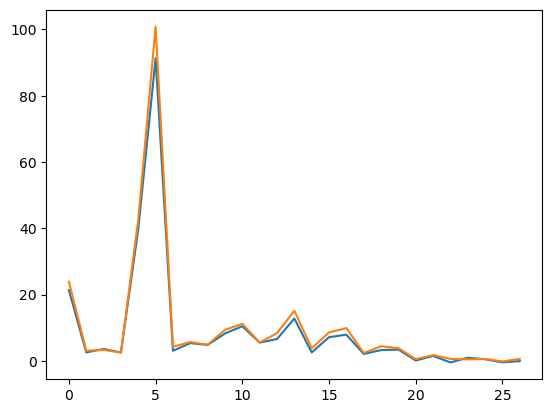

In [31]:
x = model3(torch.rand((10,10,4)))
plt.plot(range(len(x[0])), x[0].detach().numpy())
x = model3(torch.zeros((10, 10, 4)))
plt.plot(range(len(x[0])), x[0].detach().numpy())


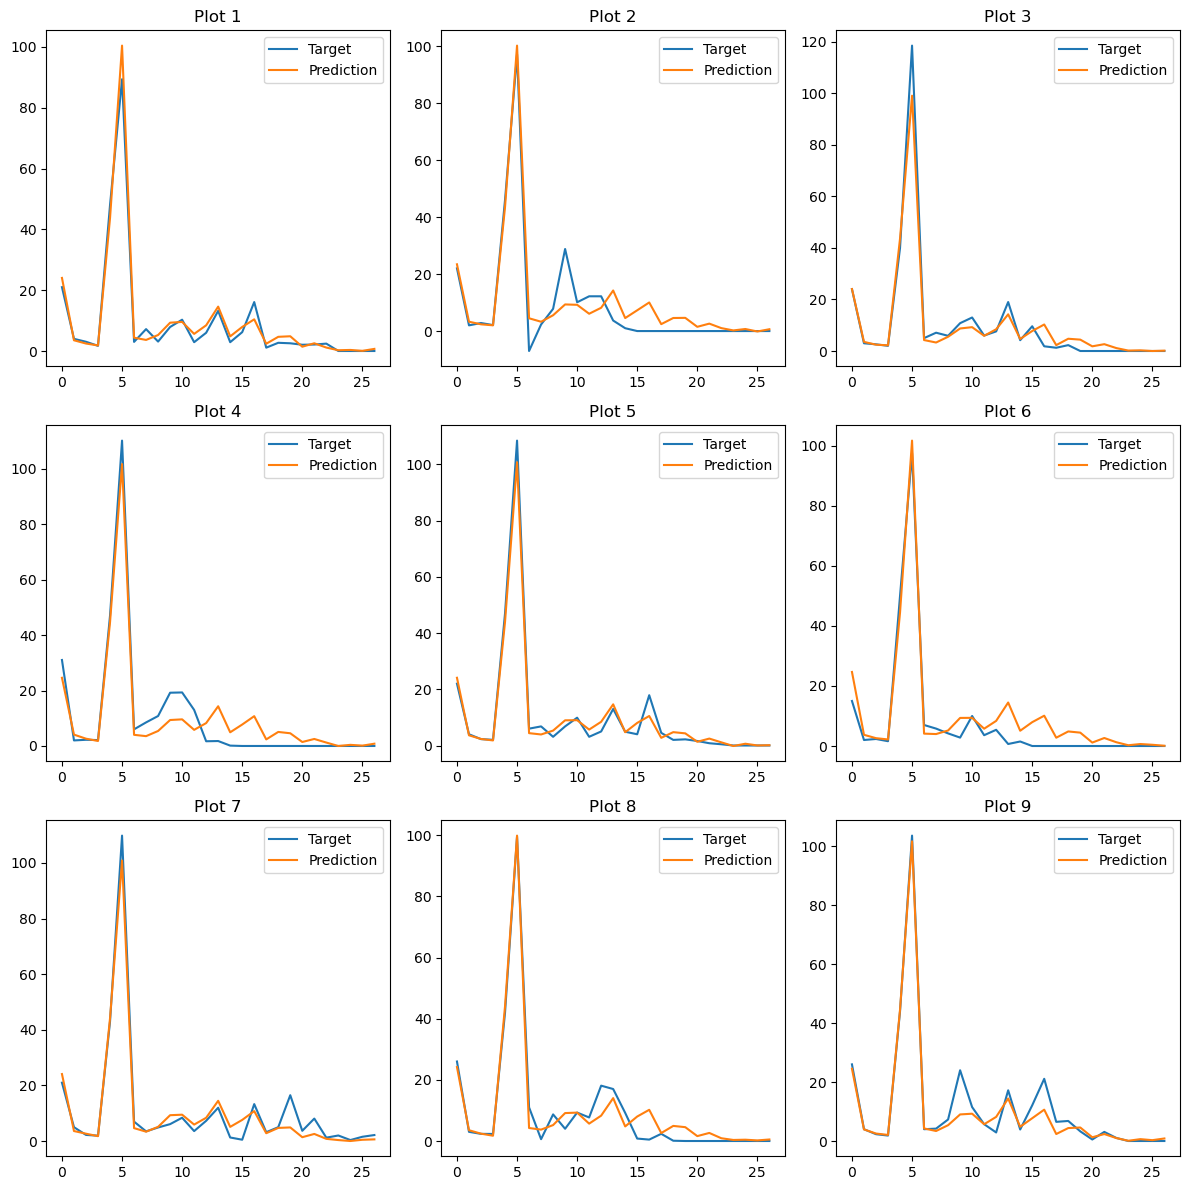

In [28]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))


for x, y in dataloader_train:
    break

for i, ax in enumerate(axs.flat):
    X = model3(x.float())[i]
    X = X.detach().numpy()
    ax.plot(range(len(y[i])), y[i])
    ax.plot(range(len(X)), X)
    ax.legend(["Target", "Prediction"])
    ax.set_title(f"Plot {i+1}")
plt.tight_layout()
plt.show()

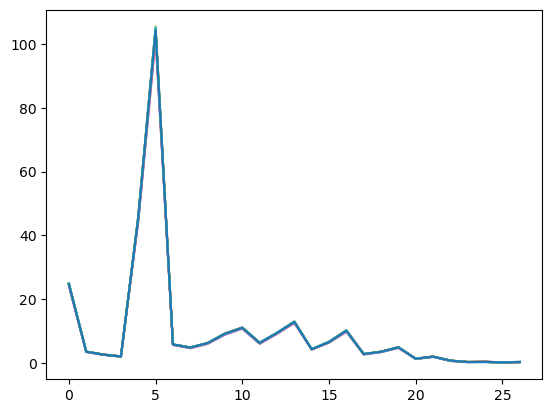

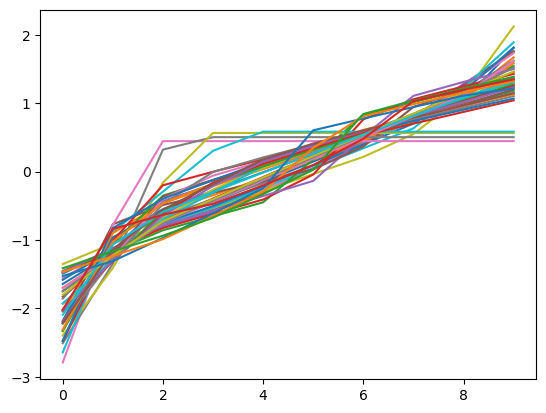

In [15]:
for i, (x, y) in enumerate(dataloader_train):
    plt.figure(0)
    X = model3(x.float())[0]
    X = X.detach().numpy()
    plt.plot(range(len(X)), X)
    ax.set_title(f"Plot {i+1}")
    plt.figure(1)
    plt.plot(x.float()[0])
    if (i == 10):
        break